# **Homework 5** Problem 2

## (a) Prepare Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%mkdir dataset/

In [3]:
!unzip /content/gdrive/MyDrive/Colab\ Notebooks/ee-596/hw-5/gtzan.zip -d dataset/

Archive:  /content/gdrive/MyDrive/Colab Notebooks/ee-596/hw-5/gtzan.zip
   creating: dataset/gtzan/_test/
  inflating: dataset/gtzan/_test/classical.00000.au  
  inflating: dataset/gtzan/_test/classical.00001.au  
  inflating: dataset/gtzan/_test/classical.00002.au  
  inflating: dataset/gtzan/_test/classical.00003.au  
  inflating: dataset/gtzan/_test/classical.00004.au  
  inflating: dataset/gtzan/_test/classical.00005.au  
  inflating: dataset/gtzan/_test/classical.00006.au  
  inflating: dataset/gtzan/_test/classical.00007.au  
  inflating: dataset/gtzan/_test/classical.00008.au  
  inflating: dataset/gtzan/_test/classical.00009.au  
  inflating: dataset/gtzan/_test/hiphop.00000.au  
  inflating: dataset/gtzan/_test/hiphop.00001.au  
  inflating: dataset/gtzan/_test/hiphop.00002.au  
  inflating: dataset/gtzan/_test/hiphop.00003.au  
  inflating: dataset/gtzan/_test/hiphop.00004.au  
  inflating: dataset/gtzan/_test/hiphop.00005.au  
  inflating: dataset/gtzan/_test/hiphop.00006.au

## (b) Audio Feature Extraction

In [4]:
%cd /content
data_root = "dataset/gtzan"  # change to the path where you store the downloaded zip file

/content


In [5]:
import os
import re
import math
import numpy as np
import librosa

In [6]:
class GenreFeatureData:
    "Music audio features for genre classification"
    hop_length = None
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = os.path.join(data_root, "_train")
    dir_devfolder = os.path.join(data_root, "_validation")
    dir_testfolder = os.path.join(data_root, "_test")
    dir_all_files = data_root

    train_X_preprocessed_data = os.path.join(data_root, "data_train_input.npy")
    train_Y_preprocessed_data = os.path.join(data_root, "data_train_target.npy")
    dev_X_preprocessed_data = os.path.join(data_root, "data_validation_input.npy")
    dev_Y_preprocessed_data = os.path.join(data_root, "data_validation_target.npy")
    test_X_preprocessed_data = os.path.join(data_root, "data_test_input.npy")
    test_Y_preprocessed_data = os.path.join(data_root, "data_test_target.npy")

    train_X = train_Y = None
    dev_X = dev_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.trainfiles_list = self.path_to_audiofiles(self.dir_trainfolder)
        self.devfiles_list = self.path_to_audiofiles(self.dir_devfolder)
        self.testfiles_list = self.path_to_audiofiles(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.trainfiles_list)
        self.all_files_list.extend(self.devfiles_list)
        self.all_files_list.extend(self.testfiles_list)

        self.timeseries_length = (
            128
        )   # sequence length == 128, default fftsize == 2048 & hop == 512 @ SR of 22050

    def load_preprocess_data(self):
        # Training set
        self.train_X, self.train_Y = self.extract_audio_features(self.trainfiles_list)
        with open(self.train_X_preprocessed_data, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_Y_preprocessed_data, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        # Validation set
        self.dev_X, self.dev_Y = self.extract_audio_features(self.devfiles_list)
        with open(self.dev_X_preprocessed_data, "wb") as f:
            np.save(f, self.dev_X)
        with open(self.dev_Y_preprocessed_data, "wb") as f:
            self.dev_Y = self.one_hot(self.dev_Y)
            np.save(f, self.dev_Y)

        # Test set
        self.test_X, self.test_Y = self.extract_audio_features(self.testfiles_list)
        with open(self.test_X_preprocessed_data, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_Y_preprocessed_data, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def extract_audio_features(self, list_of_audiofiles):
        feat_dim = 33 # TODO: define your feature dimension
        data = np.zeros(
            (len(list_of_audiofiles), self.timeseries_length, feat_dim), 
            dtype=np.float64
        )
        target = []

        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )

            # TODO: feature extraction
            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]            
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[0])[-1]
            target.append(genre)

            print(
                "Extracted features audio track %i of %i."
                % (i + 1, len(list_of_audiofiles))
            )

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot

    @staticmethod
    def path_to_audiofiles(dir_folder):
        list_of_audio = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                list_of_audio.append(directory)
        return list_of_audio

In [7]:
genre_features = GenreFeatureData()

print("Preprocessing raw audio files")
genre_features.load_preprocess_data()

Preprocessing raw audio files
Extracted features audio track 1 of 420.
Extracted features audio track 2 of 420.
Extracted features audio track 3 of 420.
Extracted features audio track 4 of 420.
Extracted features audio track 5 of 420.
Extracted features audio track 6 of 420.
Extracted features audio track 7 of 420.
Extracted features audio track 8 of 420.
Extracted features audio track 9 of 420.
Extracted features audio track 10 of 420.
Extracted features audio track 11 of 420.
Extracted features audio track 12 of 420.
Extracted features audio track 13 of 420.
Extracted features audio track 14 of 420.
Extracted features audio track 15 of 420.
Extracted features audio track 16 of 420.
Extracted features audio track 17 of 420.
Extracted features audio track 18 of 420.
Extracted features audio track 19 of 420.
Extracted features audio track 20 of 420.
Extracted features audio track 21 of 420.
Extracted features audio track 22 of 420.
Extracted features audio track 23 of 420.
Extracted fea

Print out the dimension of training features, valiation features, and test features, as well as the ground truths.

**Training Dimensions**

In [8]:
genre_features.train_X.shape

(420, 128, 33)

In [9]:
genre_features.train_Y.shape

(420, 8)

**Validation Dimensions**

In [10]:
genre_features.dev_X.shape

(120, 128, 33)

In [11]:
genre_features.dev_Y.shape

(120, 8)

**Test Dimensions**

In [12]:
genre_features.test_X.shape

(60, 128, 33)

In [13]:
genre_features.test_Y.shape

(60, 8)

**Visualize MFCC and Chromagram features.**

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import random

In [15]:
def display_mfcc_and_chroma(idx):   
  fig, axs = plt.subplots(1, 2, figsize = (20, 5))
  plt.gray()
  print(f'Filename: {genre_features.trainfiles_list[idx]}')
  librosa.display.specshow(genre_features.train_X[idx, :, 0:13].T, x_axis='time', ax=axs[0]);
  librosa.display.specshow(genre_features.train_X[idx, :, 14:26].T, y_axis='chroma', x_axis='time', ax=axs[1]) 
  plt.show();  

Filename: dataset/gtzan/_train/classical.00032.au


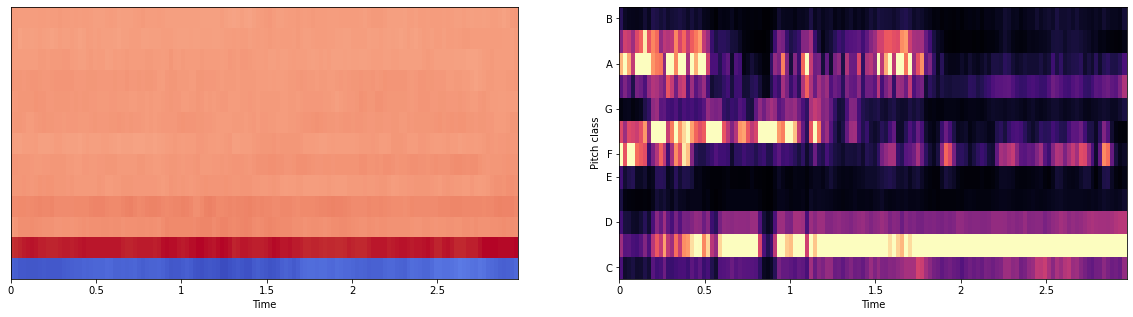

In [16]:
display_mfcc_and_chroma(0)

Filename: dataset/gtzan/_train/hiphop.00078.au


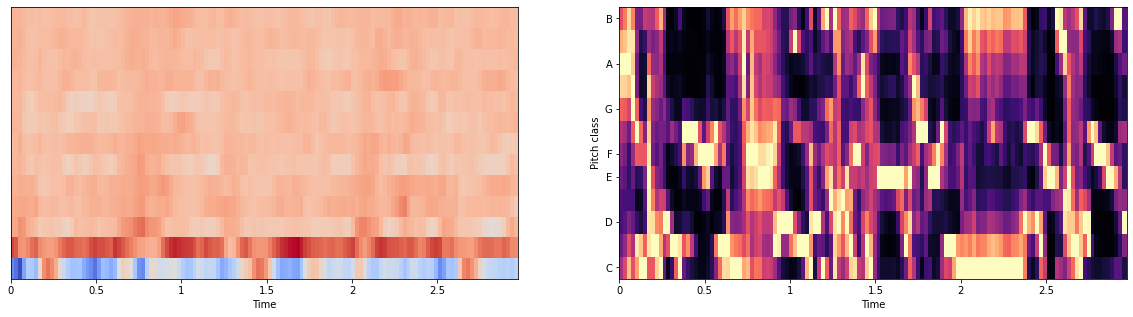

In [17]:
display_mfcc_and_chroma(113)

Filename: dataset/gtzan/_train/hiphop.00075.au


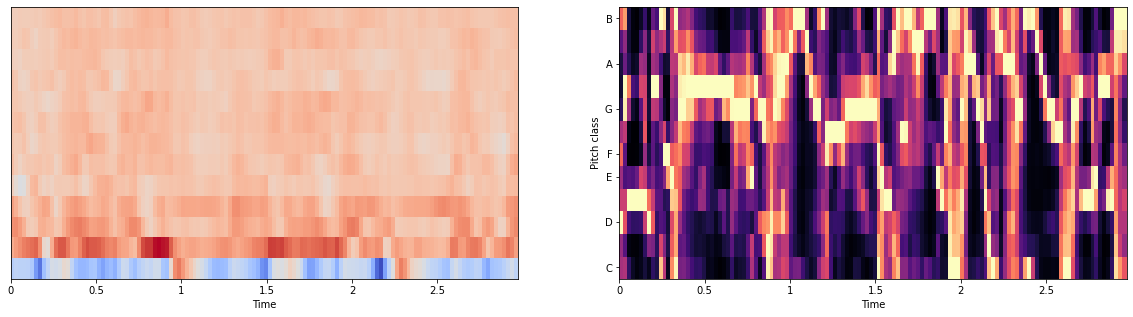

In [18]:
display_mfcc_and_chroma(401)

## (c) LSTM Implementation

In [19]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [33]:
from torch.nn.modules import dropout
class LSTM(nn.Module):
    def __init__(self, input_dim, feature_dim, batch_size, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_dim, self.feature_dim, self.num_layers, batch_first=True, dropout=.3)
        self.fc = nn.Linear(self.feature_dim, output_dim)

    def forward(self, input):        
        h0 = torch.zeros(self.num_layers, input.size(0), self.feature_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, input.size(0), self.feature_dim).requires_grad_()

        lstm_out, _ = self.lstm(input, (h0.detach(), c0.detach())) 
        logits = self.fc(lstm_out[:, -1, :])                    
        genre_scores = F.log_softmax(logits, dim=1)

        return genre_scores


    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
            torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()

In [24]:
batch_size = 30 

class AudioFeatures(Dataset):
    def __init__(self, features, labels):
        self.features = features 
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx, :, :], torch.max(self.labels[idx], 0)[1] 

train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
dev_X = torch.from_numpy(genre_features.dev_X).type(torch.Tensor)
dev_Y = torch.from_numpy(genre_features.dev_Y).type(torch.LongTensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)

train_set = AudioFeatures(train_X, train_Y)
val_set = AudioFeatures(dev_X, dev_Y)
test_set = AudioFeatures(test_X, test_Y)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)        

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    running_loss, running_acc = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.detach().item()  
        running_acc += model.get_accuracy(pred, y)
    
    return (running_loss, running_acc)

def test(dataloader, model, loss_fn):
    model.eval()

    running_loss, running_acc = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)

            loss = loss_fn(pred, y)
            running_loss += loss.detach().item()  
            running_acc += model.get_accuracy(pred, y)
            
    return (running_loss, running_acc)

In [30]:
epochs = 200
model = LSTM(33, 128, batch_size, 8, 2)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_train_batches = len(train_dataloader) 
num_val_batches = len(val_dataloader) 
train_losses,  val_losses, epochs_list = [], [], []

for epoch in range(epochs):
    train_metrics = train(train_dataloader, model, loss_function, optimizer)
    print(
        "Epoch:  %d | Train Loss: %.4f | Train Accuracy: %.2f"
        % (epoch+1, train_metrics[0] / num_train_batches, train_metrics[1] / num_train_batches)
    )    

    if (epoch+1) % 10 == 0:
      val_metrics = test(val_dataloader, model, loss_function)
      print(
        "Epoch:  %d | Val Loss: %.4f | Val Accuracy: %.2f"
        % (epoch+1, val_metrics[0] / num_val_batches, val_metrics[1] / num_val_batches)
      )

      epochs_list.append(epoch)
      train_losses.append(train_metrics[0] / num_train_batches)
      val_losses.append(val_metrics[0] / num_val_batches)

print("Done!")

Epoch:  1 | Train Loss: 1.9142 | Train Accuracy: 19.29
Epoch:  2 | Train Loss: 1.6201 | Train Accuracy: 34.52
Epoch:  3 | Train Loss: 1.4764 | Train Accuracy: 34.52
Epoch:  4 | Train Loss: 1.4092 | Train Accuracy: 35.95
Epoch:  5 | Train Loss: 1.3080 | Train Accuracy: 50.00
Epoch:  6 | Train Loss: 1.2366 | Train Accuracy: 50.48
Epoch:  7 | Train Loss: 1.2320 | Train Accuracy: 47.38
Epoch:  8 | Train Loss: 1.1944 | Train Accuracy: 52.38
Epoch:  9 | Train Loss: 1.1006 | Train Accuracy: 58.33
Epoch:  10 | Train Loss: 1.1060 | Train Accuracy: 55.71
Epoch:  10 | Val Loss: 1.0660 | Val Accuracy: 61.67
Epoch:  11 | Train Loss: 1.0243 | Train Accuracy: 61.19
Epoch:  12 | Train Loss: 0.9683 | Train Accuracy: 64.05
Epoch:  13 | Train Loss: 1.0879 | Train Accuracy: 57.14
Epoch:  14 | Train Loss: 1.1175 | Train Accuracy: 54.52
Epoch:  15 | Train Loss: 0.9874 | Train Accuracy: 61.43
Epoch:  16 | Train Loss: 1.0092 | Train Accuracy: 60.95
Epoch:  17 | Train Loss: 1.4035 | Train Accuracy: 45.95
Epoch

Visualize loss during the training.

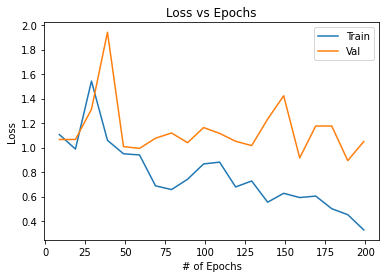

In [31]:
plt.plot(epochs_list, train_losses, label='Train')
plt.plot(epochs_list, val_losses, label='Val')
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

## (d) Evaluation and Ablation Study

**Test Accuracy**

In [32]:
metrics = test(test_dataloader, model, loss_function)
print(
  "Avg Test Loss: %.4f | Avg Test Accuracy: %.2f"
      % (metrics[0] / len(test_dataloader), metrics[1] / len(test_dataloader))
)

Avg Test Loss: 1.1114 | Avg Test Accuracy: 70.00


**MFCC Only Features**

In [34]:
mfcc_train_set = AudioFeatures(train_X[:,:,0:13], train_Y)
mfcc_val_set = AudioFeatures(dev_X[:,:,0:13], dev_Y)
mfcc_test_set = AudioFeatures(test_X[:,:,0:13], test_Y)
mfcc_train_dataloader = DataLoader(mfcc_train_set, batch_size=batch_size, shuffle=True)
mfcc_val_dataloader = DataLoader(mfcc_val_set, batch_size=batch_size)
mfcc_test_dataloader = DataLoader(mfcc_test_set, batch_size=batch_size)  

In [36]:
epochs = 50
mfcc_model = LSTM(13, 128, batch_size, 8, 2)
mfcc_loss_function = nn.CrossEntropyLoss() 
mfcc_optimizer = optim.Adam(mfcc_model.parameters(), lr=0.001)
num_train_batches = len(mfcc_train_dataloader) 
num_val_batches = len(mfcc_val_dataloader) 
train_losses, val_losses, epochs_list = [], [], []

for epoch in range(epochs):
    train_metrics = train(mfcc_train_dataloader, mfcc_model, mfcc_loss_function, mfcc_optimizer)
    print(
        "Epoch:  %d | Train Loss: %.4f | Train Accuracy: %.2f"
        % (epoch+1, train_metrics[0] / num_train_batches, train_metrics[1] / num_train_batches)
    )    

    if (epoch+1) % 10 == 0:
      val_metrics = test(mfcc_val_dataloader, mfcc_model, mfcc_loss_function)
      print(
        "Epoch:  %d | Val Loss: %.4f | Val Accuracy: %.2f"
        % (epoch+1, val_metrics[0] / num_val_batches, val_metrics[1] / num_val_batches)
      )

      epochs_list.append(epoch)
      train_losses.append(train_metrics[0] / num_train_batches)      
      val_losses.append(val_metrics[0] / num_val_batches)

print("Done!")

Epoch:  1 | Train Loss: 1.8793 | Train Accuracy: 32.38
Epoch:  2 | Train Loss: 1.2964 | Train Accuracy: 52.14
Epoch:  3 | Train Loss: 0.9872 | Train Accuracy: 62.86
Epoch:  4 | Train Loss: 0.9264 | Train Accuracy: 62.14
Epoch:  5 | Train Loss: 0.8433 | Train Accuracy: 66.43
Epoch:  6 | Train Loss: 0.7121 | Train Accuracy: 72.86
Epoch:  7 | Train Loss: 0.6128 | Train Accuracy: 76.90
Epoch:  8 | Train Loss: 0.5327 | Train Accuracy: 80.48
Epoch:  9 | Train Loss: 0.5451 | Train Accuracy: 79.76
Epoch:  10 | Train Loss: 0.4805 | Train Accuracy: 82.38
Epoch:  10 | Val Loss: 1.0223 | Val Accuracy: 69.17
Epoch:  11 | Train Loss: 0.4012 | Train Accuracy: 85.48
Epoch:  12 | Train Loss: 0.3249 | Train Accuracy: 90.95
Epoch:  13 | Train Loss: 0.3054 | Train Accuracy: 90.48
Epoch:  14 | Train Loss: 0.3296 | Train Accuracy: 89.05
Epoch:  15 | Train Loss: 0.3732 | Train Accuracy: 86.90
Epoch:  16 | Train Loss: 0.3079 | Train Accuracy: 90.48
Epoch:  17 | Train Loss: 0.2495 | Train Accuracy: 90.95
Epoch

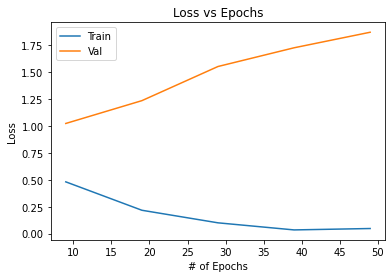

In [37]:
plt.plot(epochs_list, train_losses, label='Train')
plt.plot(epochs_list, val_losses, label='Val')
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

**Accuracy**

In [38]:
metrics = test(mfcc_test_dataloader, mfcc_model, mfcc_loss_function)
print(
  "Avg Test Loss: %.4f | Avg Test Accuracy: %.2f"
      % (metrics[0] / len(mfcc_test_dataloader), metrics[1] / len(mfcc_test_dataloader))
)

Avg Test Loss: 2.3336 | Avg Test Accuracy: 55.00


## (e) Try a customized music

In [39]:
def get_features(file):   
    length = 128
    features = np.zeros((1, length, 33), dtype=np.float64)

    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)

    features[0, :, 0:13] = mfcc.T[0:length, :]
    features[0, :, 13:14] = spectral_center.T[0:length, :]
    features[0, :, 14:26] = chroma.T[0:length, :]
    features[0, :, 26:33] = spectral_contrast.T[0:length, :]
    
    return features

In [40]:
input = get_features("/content/gdrive/MyDrive/Colab Notebooks/ee-596/hw-5/funky_track.mp3")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Prediction with MFCC Features Only

In [41]:
mfcc_model.eval()
with torch.no_grad():
  pred = mfcc_model(torch.from_numpy(input[:,:,0:13]).type(torch.Tensor))
  print(GenreFeatureData().genre_list[torch.max(pred, 1)[1]])

jazz


Prediction with All Features

In [42]:
model.eval()
with torch.no_grad():
  pred = model(torch.from_numpy(input).type(torch.Tensor))
  print(GenreFeatureData().genre_list[torch.max(pred, 1)[1]])

jazz


**Question** : How is the prediction result?

**Answer** : The predicted cateogry is Jazz, but the expected category is Disco. Sad.